<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_3_%D0%9E_%D0%B2%D0%BA%D1%83%D1%81%D0%BD%D0%BE%D0%B9_%D0%B8_%D0%B7%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D0%B8%D1%89%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Проект 3. О вкусной и здоровой пище

# Feature Engineering
###  +Ответы на вопросы заданий

In [47]:
import pandas as pd
import numpy as np

RANDOM_SEED = 36

# rest.loc[0:100, 'reviews'].to_list()
path = 'https://raw.githubusercontent.com/akitim/datasets/main/main_task_new.csv'
rest = pd.read_csv(path)

rest.drop(['URL_TA', 'ID_TA'], axis=1, inplace=True)
rest.columns = ['id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'rev_number', 'reviews']

# 2.1 Задание 1
# Какие столбцы НЕ содержат пропущенных (None) значений?
# rest.info()
 
print('\nЕсть пропуски в столбцах:\n',
*list(rest.loc[:, rest.apply(pd.isna).any(axis=0)].columns))
 
print('\nНет пропусков в столбцах:\n',
*list(rest.loc[:, ~rest.apply(pd.isna).any(axis=0)].columns), '\n')
 
# 2.2 Задание 2
#rest.loc[0, :].apply(type) != str
 
# 2.3 Задание 3
#Приведение 'кухни' к списку
#rest.loc[0, 'Cuisine Style'].split(', ')
#[s.replace('[', '').replace(']', '').replace("'", "") for s in rest.loc[0, 'Cuisine Style'].s изplit(', ')]

# 4.1 Вопросы о ценах
rest.loc[:, 'price_range'].dropna().unique()
rest.loc[rest.loc[:, 'price_range'] == '$$ - $$$', 'price_range'].count()

# 4.2 Вопрос о городах
len(rest.loc[:, 'city'].unique())

# 4.3 Вопросы о кухнях
rest.loc[:, 'cuisine'] =\
rest.loc[:, 'cuisine'].fillna(value='[]').apply(
    lambda cuisine_list_for_id: \
    [s.replace("'", "") for s in cuisine_list_for_id[2:-2].split(', ')]
)

cuisine_list = []
for cuisine in rest.loc[:, 'cuisine']:
    cuisine_list += cuisine
cuisines_total = len(set(cuisine_list).difference(set([''])))
# cuisines_total = len(set(cuisine_list)) - 1

from collections import Counter
Counter(cuisine_list).most_common(1)[0][0]

round(
    rest.loc[:, 'cuisine'].apply(lambda x: len(x) if x != [] else 1).mean(),
    1
)

# 4.4 Вопросы об отзывах
import re
from datetime import datetime as dat

def rev_dates(s):
    date_regex = re.compile(r'(\d+/\d+/\d+)') # компилируем регулярку для поиска дат в формате dd/mm/YYYY
    str_date_ls = date_regex.findall(s)
    if str_date_ls != []:
        # str_date_ls = date_regex.findall(s)
        enum = list(enumerate(str_date_ls))
        f = ['%m/%d/%Y' if int(e[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y' for e in enum]
        return [dat.strptime(e[1], f[e[0]]) for e in enum] #dat.strptime(str_date_ls[0], f[0])
    else:
        return [dat(1970, 1, 1, 0, 0)] #strftime('%m/%d/%Y', '01/01/1970')

# когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
most_recent_rev_date =\
rest.loc[:, 'reviews'].apply(lambda s: rev_dates(s)[0]).max()
dat.strftime(most_recent_rev_date, '%Y-%m-%d') #->2018-02-26

# Какое максимальное количество дней отделяет даты публикации отзывов,
# размещённых на сайте ресторана? Введите количество дней в виде целого числа.
def last_rev_date_delta(dates):
    if len(dates) >= 3:
        return abs(dates[2] - dates[1]).days
    else:
        return abs(dates[0] - dates[-1]).days

# добавляем в данные столбец с кол-вом дней между двумя последними отзывами
rest.loc[:, 'delta'] =\
rest.loc[:, 'reviews'].apply(lambda s: last_rev_date_delta(rev_dates(s))) #.sort_values(ascending=False)
# rest['delta'].dt.days.astype(int).hist(log=True, bins=50);

#считаем кол-во кухонь в меню ресторана, добавляем соотв. столбец
rest.loc[:, 'n_of_cuisines'] = rest.loc[:, 'cuisine'].apply(lambda x: len(x) if x != [] else 1)
# rest.loc[:, 'n_of_cuisines'].hist(log=True, bins=50);

# добавляем столбец с населением города, в кот. находится ресторан
# rest.loc[:, 'city'].unique()
population = {
       'Paris': 2176, 'Stockholm': 1656, 'London': 10840, 'Berlin': 3664,
       'Munich': 1553, 'Oporto': 232, 'Milan': 3144, 'Bratislava': 433,
       'Vienna': 1911, 'Rome': 2860, 'Barcelona': 1620, 'Madrid': 3223,
       'Dublin': 555, 'Brussels': 1209, 'Zurich': 415, 'Warsaw': 1794,
       'Budapest': 1752, 'Copenhagen': 799, 'Amsterdam': 873, 'Lyon': 516,
       'Hamburg': 1899, 'Lisbon': 507, 'Prague': 1324, 'Oslo': 697, 
       'Helsinki': 658, 'Edinburgh': 488, 'Geneva': 202, 'Ljubljana': 296,
       'Athens': 664, 'Luxembourg': 125, 'Krakow': 781}
rest.loc[:, 'population'] = rest.loc[:, 'city'].apply(lambda city: population[city])

# добавляем столбец с подушевым ВВП по ППС города, в кот. нах. ресторан
is_capital = {'Paris': 1, 'Stockholm': 1, 'London': 1, 'Berlin': 1,
       'Munich': 0, 'Oporto': 0, 'Milan': 0, 'Bratislava': 1,
       'Vienna': 1, 'Rome': 1, 'Barcelona': 0, 'Madrid': 1,
       'Dublin': 1, 'Brussels': 1, 'Zurich': 0, 'Warsaw': 1,
       'Budapest': 1, 'Copenhagen': 1, 'Amsterdam': 1, 'Lyon': 0,
       'Hamburg': 0, 'Lisbon': 1, 'Prague': 1, 'Oslo': 1, 
       'Helsinki': 1, 'Edinburgh': 0, 'Geneva': 0, 'Ljubljana': 1,
       'Athens': 1, 'Luxembourg': 1, 'Krakow': 0
}
rest.loc[:, 'is_capital'] = rest.loc[:, 'city'].apply(lambda city: is_capital[city])

# добавляем столбец с подушевым ВВП по ППС города, в кот. нах. ресторан
gdp = {
    'Paris': 61883, 'Stockholm': 61754, 'London': 58827, 'Berlin': 37601,
    'Munich': 69844, 'Oporto': 24819, 'Milan': 51768, 'Bratislava': 67841,
    'Vienna': 46787, 'Rome': 41475, 'Barcelona': 45752, 'Madrid': 43074,
    'Dublin':30000, 'Brussels': 54634, 'Zurich': 64302, 'Warsaw': 49722,
    'Budapest': 37399, 'Copenhagen': 54197, 'Amsterdam': 60857, 'Lyon': 46913,
    'Hamburg': 52947, 'Lisbon': 34782, 'Prague': 48160, 'Oslo': 64673,
    'Helsinki': 49760, 'Edinburgh': 44059, 'Geneva': 62115, 'Ljubljana': 39763,
    'Athens': 32167, 'Luxembourg': 88312, 'Krakow': 29695
}
rest.loc[:, 'gdp'] =\
 rest.loc[:, 'city'].apply(lambda city: gdp[city])


#количество предприятий общепита в стране нахождения ресторана
n_of_food_serv = {
    'Paris': 161466, 'Stockholm': 23208, 'London': 88841, 'Berlin': 136091,
    'Munich': 136091, 'Oporto': 31363, 'Milan': 155875, 'Bratislava': 10917,
    'Vienna': 27348, 'Rome': 155875, 'Barcelona': 72657, 'Madrid': 72657,
    'Dublin': 7993, 'Brussels': 30773, 'Zurich': 11961, 'Warsaw': 39291,
    'Budapest': 16850, 'Copenhagen': 8983, 'Amsterdam': 30502, 'Lyon': 161466,
    'Hamburg': 136091, 'Lisbon': 31363, 'Prague': 45623, 'Oslo': 6605,
    'Helsinki': 7769, 'Edinburgh': 88841, 'Geneva': 11961, 'Ljubljana': 4369,
    'Athens': 39978, 'Luxembourg': 1475, 'Krakow': 39291
}
rest.loc[:, 'n_of_food_serv'] = rest.loc[:, 'city'].\
    apply(lambda city: n_of_food_serv[city])

#количество ресторанов в городе согласно датасету на душу населения города
n_of_rest = rest.loc[:, 'city'].value_counts()

rest.loc[:, 'n_of_rest'] = rest.loc[:, 'city'].\
    apply(lambda city: n_of_rest[city])

rest.loc[:, 'n_of_rest_per_capita'] = rest.loc[:, 'n_of_rest'] /\
    rest.loc[:, 'population']

# получаем dummies из столбца cuisine и прикрепляем его к осн. датафрейму
top_cuisines_num = 5  #кол-во самых распространненных кухонь, можно взять любое

# создаем список самых популярных top_cuisines_num типов кухонь
top_cuisines = rest.loc[rest.loc[:, 'cuisine'].apply(lambda x: x != ['']), :].\
    explode('cuisine').groupby('cuisine')['cuisine'].\
        count().sort_values(ascending=False).head(top_cuisines_num).index

# прикрепляем к датафрейму
top_cuisines = list(map(lambda x: '_' + x, top_cuisines))
rest = pd.concat([
         rest,
         pd.get_dummies(rest.explode('cuisine'), columns=['cuisine'], prefix='').
         sum(level=0).loc[:, top_cuisines]],
         axis=1
)
# остальные кухни формируют один признак
# rest['other_cuisines'] = rest[top_cuisines].sum(axis=1).\
#     apply(lambda oc: int(not bool(oc)))

# города в dummies
top_cities_num = 5
top_cities = rest.loc[:, 'city'].value_counts().head(top_cities_num).index
top_cities = list(map(lambda x: '_' + x, top_cities))
rest = pd.concat([
         rest,
         pd.get_dummies(rest, columns=['city'], prefix='').
         loc[:, top_cities]],
         axis=1
)

#квантизуем признак price_range

price_range_quantize = {
    '$': 1, '$$ - $$$': 2, '$$$$': 3
}
rest.loc[:, 'price_range']=\
rest.loc[:, 'price_range'].apply(lambda x: 0 if pd.isna(x) else price_range_quantize[x])

# # добавляем признак кол-ва id
# n_of_ids = rest.loc[:, 'id'].value_counts()
# rest.loc[:, 'n_of_ids'] = rest.loc[:, 'id'].apply(lambda id: n_of_ids[id])

# # добавляем признак размаха ranking по городам
# ranking_range_by_city = rest.groupby('city')['ranking'].max() -\
#     rest.groupby('city')['ranking'].min()
# rest.loc[:, 'ranking_range'] = rest.loc[:, 'city'].\
#     apply(lambda city: ranking_range_by_city[city])

# добавляем признак суммарного ranking по городам
ranking_sum_by_city = rest.groupby('city').sum()['ranking']
rest.loc[:, 'ranking_summated'] = rest.loc[:, 'city'].\
    apply(lambda city: ranking_sum_by_city[city])

# парсим отзывы и добавляем признаки на их основе
# def cleanse(review):
#     def strip_to_word(str_):
#         return str_.replace(',', '').replace("'", '').\
#                 replace('[', '').replace(']', '').\
#                 replace('.', '').replace('''"''', '').\
#                 replace('!', '').replace('?', '').lower()
#     return [strip_to_word(str_) if strip_to_word(str_).isalpha() else ''\
#             for str_ in review.split(' ')]

# # plt.rcParams['figure.figsize'] = (12, 8)
# n_of_top_words = 100

# rev_groups = []
# b = {'l': 1.0, 'r': 2.0}, {'l': 2.5, 'r': 3.5}, {'l': 4.0, 'r': 5.0}
# for i in range(len(b)):
#     rev_groups += [
#                   rest[(rest.rating >= b[i]['l']) & (rest.rating <= b[i]['r'])].reviews.\
#             apply(cleanse).explode().value_counts(ascending=False)
#     ]

# words_to_drop = ['', 'i', 'the', 'a', 'for', 'of', 'to', 'with', 'and', 'very',\
#                  'but', 'in', 'off', 'was', 'your', 'my', 'do', 'if', 'all']
# word_occurence = pd.concat([group.drop(words_to_drop).head(n_of_top_words)\
#                             for group in rev_groups], axis=1)
# word_occurence.columns = ['group' + f'{i+1}' for i in range(len(b))]
# word_occurence.fillna(0, inplace=True)

# word_occurence = word_occurence[word_occurence.apply(
#     lambda row: any([row.sum() == occ and occ for occ in row]),
#     axis=1
# )]

# group_words = [word_occurence[word_occurence[col] != 0].index.to_list()\
#  for col in word_occurence.columns]

# for i in range(len(b)):
#     rest[word_occurence.columns[i]] = rest['reviews'].apply(
#     lambda rev: sum([1 if word in rev else 0 for word in group_words[i]])
#     )

# Какие признаки возьмем в модель?
# ==================================
# ranking
# rev_number
# delta - кол-во дней между двумя последними отзывами +
# n_of_cuisines - кол-во кухонь, представленных в ресторане +
# population - население города, в котором расположен ресторан +
# gdp - подушевой ВВП по ППС города (USD)


Есть пропуски в столбцах:
 cuisine price_range rev_number

Нет пропусков в столбцах:
 id city ranking rating reviews 



In [53]:
n_of_top_words = 50

rev_groups = []
b = {'l': 1.0, 'r': 2.0}, {'l': 2.5, 'r': 3.0}, {'l': 3.5, 'r': 3.5},\
    {'l': 4.0, 'r': 4.0}, {'l': 4.5, 'r': 4.5}, {'l': 5.0, 'r': 5.0}
for i in range(len(b)):
    rev_groups += [
                  rest[(rest.rating >= b[i]['l']) & (rest.rating <= b[i]['r'])].reviews.\
            apply(cleanse).explode().value_counts(ascending=False)
    ]

words_to_drop = ['', 'i', 'the', 'a', 'for', 'of', 'to', 'with', 'and', 'very',\
                 'but', 'in', 'off', 'was', 'your', 'my', 'do', 'if', 'all']
word_occurence = pd.concat([group.drop(words_to_drop).head(n_of_top_words)\
                            for group in rev_groups], axis=1)
word_occurence.columns = ['group' + f'{i+1}' for i in range(len(b))]
word_occurence.fillna(0, inplace=True)

group_words = [word_occurence[word_occurence[col] != 0].index.to_list()\
 for col in word_occurence.columns]

for i in range(len(b)):
    rest[word_occurence.columns[i]] = rest['reviews'].apply(
    lambda rev: sum([1 if word in rev else 0 for word in group_words[i]])
    )



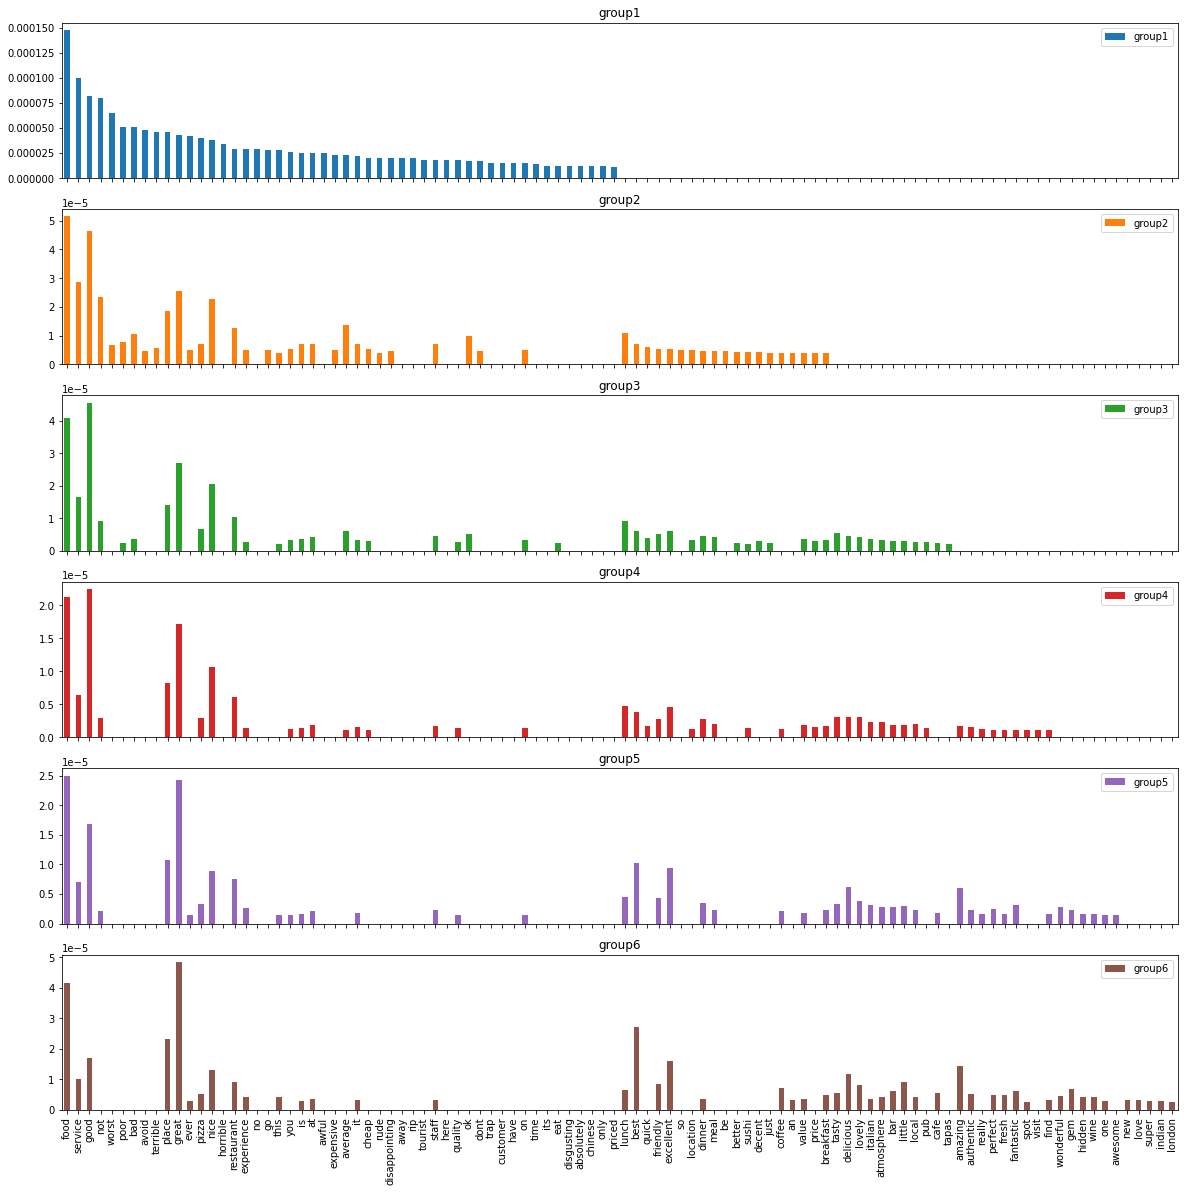

In [62]:
n_of_rest_in_group = [
    rest[(rest['rating'] >= b[i]['l']) & (rest['rating'] <= b[i]['r'])]\
        ['id'].count() for i in range(len(b))
]
word_occurence = word_occurence / n_of_rest_in_group #.apply(lambda col: col/)
plt.rcParams['figure.figsize'] = (20, 20)
word_occurence.plot(kind='bar', subplots=True);

#Заполнение пропусков

In [41]:
# before = rest.loc[rest.loc[:, 'price_range'] != 0 , 'price_range']

#первый вариант заполнения пропусков в rev_number средним по всем ресторанам
# mean_NoR = rest.loc[:, 'rev_number'].mean()
# rest.loc[:, 'rev_number'] = \
# rest.loc[:, 'rev_number'].apply(lambda r: r if not(pd.isna(r)) else mean_NoR)

# второй вариант заполнения пропусков в rev_number средним по городу
mean_NoR_by_city = dict([
      (city, rest.loc[rest.loc[:, 'city'] == city, 'rev_number'].mean())\
      for city in rest.loc[:, 'city'].unique()
])

rest.loc[:, 'rev_number'].\
    fillna(rest.loc[:, 'city'].\
           apply(lambda c: mean_NoR_by_city[c]), inplace=True)

#заполняем пропуски в price_range - под вопросом

# from random import randint

# def fill_price(city, city_pr_distr): # distr -> distr[city][distr[city].index != 0]
#     borders = [city_pr_distr[0:i+1].sum() for i in range(len(city_pr_distr))]
    
#     pick_rand = randint(0, borders[-1])
#     for border in enumerate(borders):
#         if pick_rand < border[1]:
#             return city_pr_distr.index[border[0]]

# distr = rest.groupby('city')['price_range'].value_counts()

# rest.loc[rest.loc[:, 'price_range'] == 0, 'price_range'] = \
# rest.loc[rest.loc[:, 'price_range'] == 0, 'city'].apply(
#     lambda city: fill_price(city, distr[city][distr[city].index != 0])
# )
# # rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'price_range'] = 0

# rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'price_range'] = \
# rest.loc[rest.loc[:, 'price_range'].apply(pd.isna), 'city'].apply(
#     lambda city: fill_price(city, distr[city][distr[city].index != 0])
# )

#Полиномиальные черты

In [42]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

pf = PolynomialFeatures(3)
poly_features = pf.fit_transform(
    rest.loc[:, ['rev_number', 'ranking']]
    # rest.loc[:, ['delta', 'gdp']]
)
# pd.DataFrame(poly_features).iloc[:, 1:9]
rest = pd.concat([
         rest,
         pd.DataFrame(poly_features) #.iloc[:, 1:9]
         ],
         axis=1
)
rest.sample(5)

,id,city,cuisine,ranking,rating,price_range,rev_number,reviews,delta,n_of_cuisines,population,is_capital,gdp,n_of_food_serv,n_of_rest,n_of_rest_per_capita,_Vegetarian Friendly,_European,_Mediterranean,_Italian,_Vegan Options,_London,_Paris,_Madrid,_Barcelona,_Berlin,ranking_summated,0,1,2,3,4,5,6,7,8,9
39126,id_30,Madrid,"[Spanish, Mediterranean, European, Vegetarian ...",31.0,4.5,2,649.0,"[['So nice :)', 'Caring and friendly staff and...",180,6,3223,1,43074,72657,3108,0.964319,1,1,1,0,1,0,0,1,0,0,13639219.0,1.0,649.0,31.0,421201.0,20119.0,961.0,273359449.0,13057231.0,6.236890e+05,2.979100e+04
17139,id_6720,Paris,"[International, Vegetarian Friendly]",6721.0,3.5,2,132.0,"[['A very average place', 'Poor, poor, poor'],...",107,2,2176,1,61883,161466,4897,2.250460,1,0,0,0,0,0,1,0,0,0,33950960.0,1.0,132.0,6721.0,17424.0,887172.0,45171841.0,2299968.0,117106704.0,5.962683e+09,3.035999e+11
34731,id_7357,Barcelona,[American],7358.0,2.5,2,78.0,"[['Terrible service', 'Good food, nice atmosph...",18,1,1620,0,45752,72657,2734,1.687654,0,0,0,0,0,0,0,0,1,0,10701270.0,1.0,78.0,7358.0,6084.0,573924.0,54140164.0,474552.0,44766072.0,4.222933e+09,3.983633e+11
4785,id_6890,Madrid,[],6893.0,3.5,0,7.0,"[['Stopped here for cheap food, was pleasantl....",198,1,3223,1,43074,72657,3108,0.964319,0,0,0,0,0,0,0,1,0,0,13639219.0,1.0,7.0,6893.0,49.0,48251.0,47513449.0,343.0,337757.0,3.325941e+08,3.275102e+11
29191,id_672,Helsinki,[],673.0,4.5,0,3.0,"[['Last resort', 'Best value sports bar in Hel...",140,1,658,1,49760,7769,376,0.571429,0,0,0,0,0,0,0,0,0,0,213158.0,1.0,3.0,673.0,9.0,2019.0,452929.0,27.0,6057.0,1.358787e+06,3.048212e+08


#Черновик 0

In [ ]:
import pandas as pd
import numpy as np

RANDOM_SEED = 36

# rest.loc[0:100, 'reviews'].to_list()
path = 'https://raw.githubusercontent.com/akitim/datasets/main/main_task_new.csv'
rest = pd.read_csv(path)

rest.drop(['URL_TA', 'ID_TA'], axis=1, inplace=True)
rest.columns = ['id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'rev_number', 'reviews']

In [ ]:
import matplotlib.pyplot as plt
from random import randint

# rest.reviews.to_list()
# fig = []
# for i in range(1, 11, 1):
#     fig += [plt.figure(i)]
#     rest.rating[rest.rating == i/2].hist();
#     plt.title (f'rating = {i/2}')
#     # plt.show()

# rest.rating[rest.rating > 0 ].hist();

def cleanse(review):
    def strip_to_word(str_):
        return str_.replace(',', '').replace("'", '').\
                replace('[', '').replace(']', '').\
                replace('.', '').replace('''"''', '').\
                replace('!', '').replace('?', '').lower()
    return [strip_to_word(str_) if strip_to_word(str_).isalpha() else ''\
            for str_ in review.split(' ')]

plt.rcParams['figure.figsize'] = (12, 8)
N = 60

rev_groups = []
b = {'l': 1.0, 'r': 2.5}, {'l': 3.0, 'r': 4.0}, {'l': 4.5, 'r': 5.0}
for i in range(len(b)):
    rev_groups += [
                  rest[(rest.rating >= b[i]['l']) & (rest.rating <= b[i]['r'])].reviews.\
            apply(cleanse).explode().value_counts(ascending=False)
    ]

words_to_drop = ['', 'i', 'the', 'a', 'for', 'of', 'to', 'with', 'and', 'very',\
                 'but', 'in', 'off', 'was', 'your', 'my', 'do', 'if', 'all']
word_occurence = pd.concat([group.drop(words_to_drop).head(N)\
                            for group in rev_groups], axis=1)
word_occurence.columns = ['bad', 'average', 'good']
word_occurence.fillna(0, inplace=True)

word_occurence = word_occurence[word_occurence.apply(
    lambda row: any([row.sum() == occ and occ for occ in row]),
    axis=1
)]

group_words = [word_occurence[word_occurence[col] != 0].index.to_list()\
 for col in word_occurence.columns]

for i in range(len(b)):
    rest[word_occurence.columns[i]] = rest['reviews'].apply(
    lambda rev: sum([1 if word in rev else 0 for word in group_words[i]])
    )
display(rest.sample(10))  
# ==========================================================================

# bad = rest[(rest.rating >= 1.0) & (rest.rating <= 2.5)].reviews.\
#             apply(cleanse).explode().value_counts(ascending=False)

# average = rest[(rest.rating >= 3.0) & (rest.rating <= 4.0)].reviews.\
#             apply(cleanse).explode().value_counts(ascending=False)

# good = rest[(rest.rating >= 4.5) & (rest.rating <= 5.0)].reviews.\
#             apply(cleanse).explode().value_counts(ascending=False)

# word_occurence1 = pd.concat([bad.drop(words_to_drop).head(N),
#                average.drop(words_to_drop).head(N),
#                good.drop(words_to_drop).head(N)],
#                axis=1
# )
# word_occurence1.columns = ['bad', 'average', 'good']
# word_occurence1.fillna(0, inplace=True)

# # word_occurence = word_occurence.\
# #     apply(lambda col: col / col.sum(), axis=0)
# # word_occurence.plot(kind='bar', subplots=True);

# word_occurence1 = word_occurence1[word_occurence1.apply(
#     lambda row: any([row.sum() == occ and occ for occ in row]),
#     axis=1
# )]

# bad_words = word_occurence1[word_occurence1.bad != 0].index.to_list()
# average_words = word_occurence1[word_occurence1.average != 0].index.to_list()
# good_words = word_occurence1[word_occurence1.good != 0].index.to_list()

# rest['bad'] = rest.reviews.apply(
#     lambda rev: sum([1 if word in rev else 0 for word in bad_words])
# )

# rest['average'] = rest.reviews.apply(
#     lambda rev: sum([1 if word in rev else 0 for word in average_words])
# )

# rest['good'] = rest.reviews.apply(
#     lambda rev: sum([1 if word in rev else 0 for word in good_words])
# )

# display(rest.sample(10))
# word_occurence

# rest[(rest.rating >= 3.0) & (rest.rating <= 4.0)].reviews
# rest[(rest.rating >= 4.5) & (rest.rating <= 5.0)].reviews

,id,city,cuisine,ranking,rating,price_range,rev_number,reviews,bad,average,good
26075,id_1405,Stockholm,NaN,1406.0,4.0,NaN,16.0,"[['Friendly service, awful falafel', 'Okay pla...",1,0,1
19684,id_2262,Budapest,"['European', 'Grill']",2263.0,3.0,$$ - $$$,167.0,"[['Nice place, but grill need to be improved.'...",0,0,0
32147,id_9652,London,"['Indian', 'Asian', 'Vegetarian Friendly']",9661.0,3.5,$$ - $$$,92.0,"[['Great value', 'Great food but....'], ['09/2...",0,0,0
8133,id_495,Helsinki,"['Chinese', 'Sushi']",496.0,4.0,$$ - $$$,15.0,"[['One of the better buffets', 'Good sushi buf...",2,1,0
33087,id_2168,Lisbon,NaN,2171.0,4.0,NaN,12.0,"[['wonderful dinner', 'Best Brazilian rodízio ...",0,0,1
27466,id_4780,London,"['Italian', 'Mediterranean', 'European', 'Pizz...",4789.0,5.0,$,30.0,"[['Match Day Pizza', 'Wonderful Pizza!!'], ['0...",0,0,0
21956,id_2957,Rome,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",2958.0,4.0,$$ - $$$,153.0,"[['Family get together', 'Pizzeria with good c...",1,0,0
12955,id_404,Hamburg,"['Asian', 'Thai', 'Vegetarian Friendly']",405.0,4.0,$$ - $$$,97.0,"[['Really Nice and cozy dinner place', 'Decent...",0,0,1
26776,id_7759,Madrid,"['Bar', 'Cafe', 'Mediterranean', 'European', '...",7766.0,3.0,$$ - $$$,305.0,"[['Great Patio on the Plaza Mayor', 'Nice plac...",0,0,0
17372,id_3532,Prague,"['Czech', 'Central European', 'European']",3540.0,3.5,$$ - $$$,49.0,"[['Tasty but not enough', 'Nice Czech fast-foo...",2,0,0


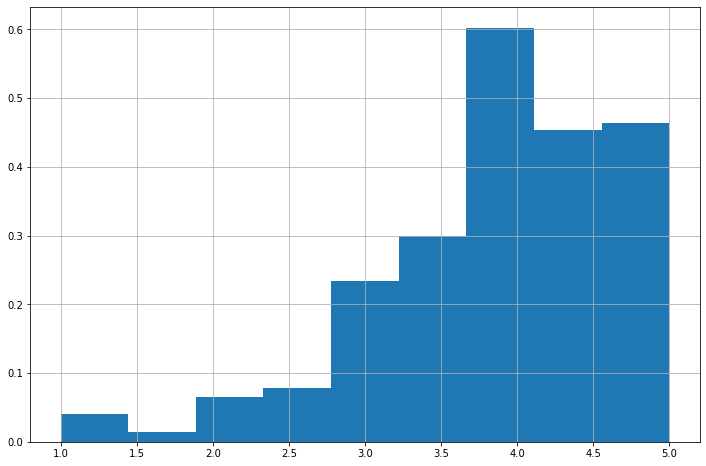

In [ ]:
reviews = rest.reviews.apply(cleanse) #[rest.reviews == '']
rest[reviews.apply(
    lambda review: all([word == '' for word in review])
)]['rating'].hist(bins=9, density=True);
# rest[rest.reviews == '']
# rest.reviews.apply(cleanse)

In [ ]:
#Предобработка
# rest.loc[0, :].apply(type)
# rest.dropna(axis=0, inplace=True)

rest.loc[:, 'cuisine'] =\
rest.loc[:, 'cuisine'].apply(
    lambda cuisine_list_for_id: \
        [s.replace("'", "") for s in cuisine_list_for_id[2:-2].split(', ')]\
            if not(pd.isna(cuisine_list_for_id)) else []
)

            # rest.loc[0, 'Cuisine Style'][0]
            # rest.get_dummies()
# rest

ValueError: ignored

#Тепловая карта корреляций

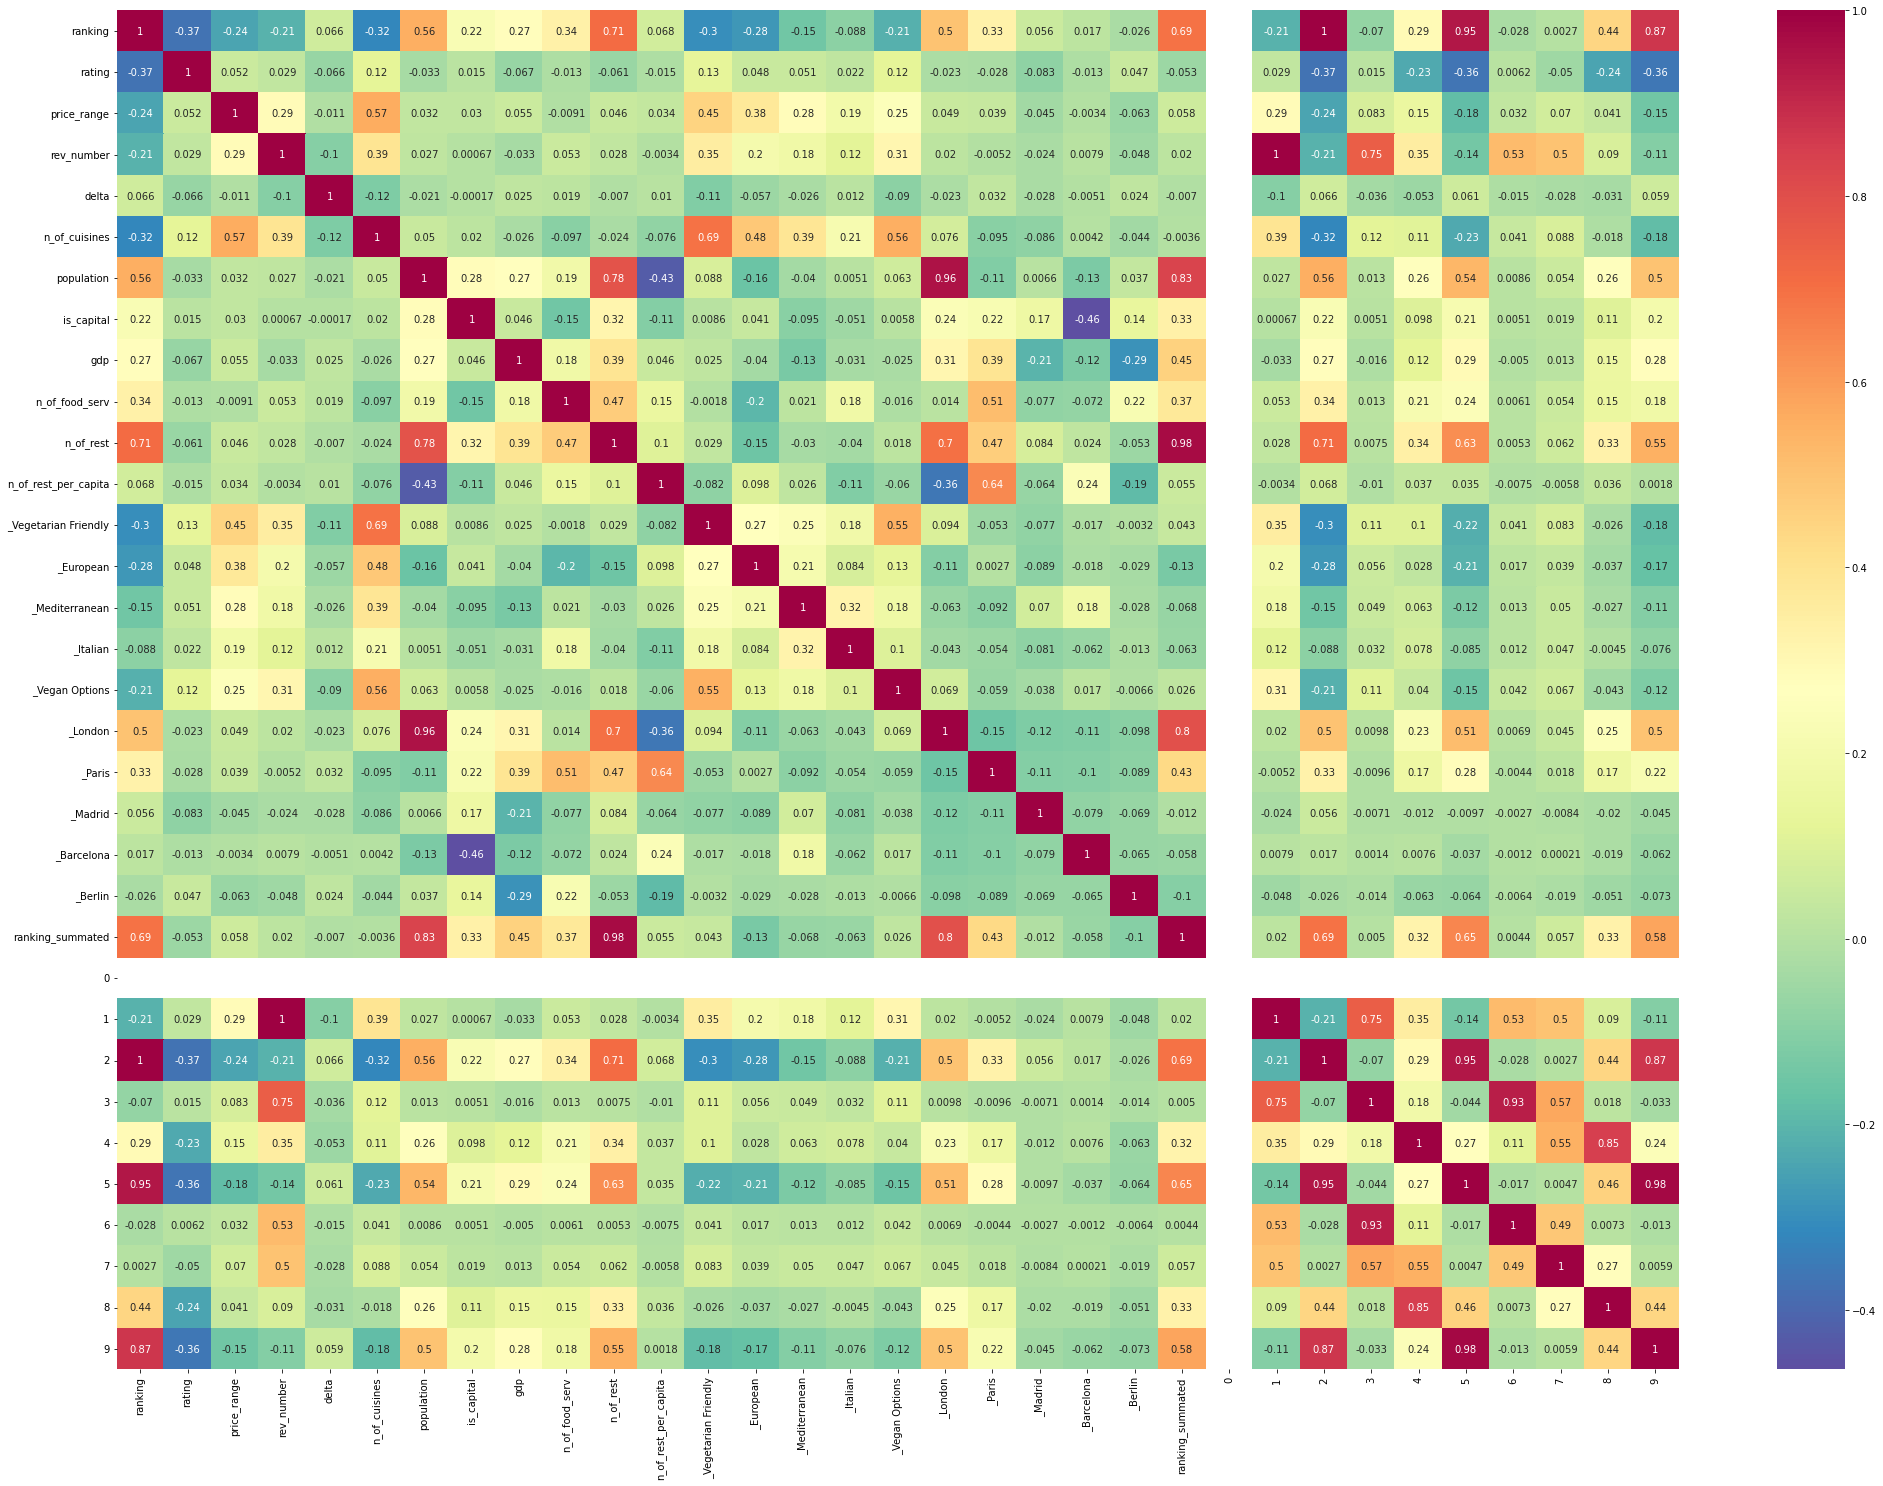

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (35, 25))

sns.heatmap(rest.corr(), annot = True, cmap = 'Spectral_r');

In [ ]:
# rest.loc[:, 'rank/n_of_ids'] = rest.loc[:, 'ranking'] / rest.loc[:, 'n_of_ids']
# rest.drop(columns = ['ranking', 'n_of_ids'], inplace=True)

# rest.loc[:, '4+7'] = rest.loc[:, 4] + rest.loc[:, 7]
# rest.drop(columns = [4, 7], inplace=True)

In [ ]:
# rest.loc[:, 'Vegan'] = rest.loc[:, '_Vegan Options'] + rest.loc[:, '_Vegetarian Friendly']
# rest.drop(columns = ['_Vegan Options', '_Vegetarian Friendly'], inplace=True)

#Данные в модель

,ranking,price_range,rev_number,delta,n_of_cuisines,is_capital,gdp,n_of_food_serv,n_of_rest_per_capita,_Vegetarian Friendly,_European,_Mediterranean,_Italian,_Vegan Options,_Paris,_Madrid,_Barcelona,_Berlin,ranking_summated,4,7
0,5570.0,2,194.0,41,3,1,61883,161466,2.250460,0,1,0,0,0,1,0,0,0,33950960.0,1080580.0,2.096325e+08
1,1537.0,0,10.0,382,1,1,61754,23208,0.495169,0,0,0,0,0,0,0,0,0,1018757.0,15370.0,1.537000e+05
2,353.0,3,688.0,2,7,1,58827,88841,0.531089,1,0,0,0,1,0,0,0,0,47198545.0,242864.0,1.670904e+08
3,3458.0,0,3.0,0,1,1,37601,136091,0.588155,0,0,0,0,0,0,0,0,1,7038741.0,10374.0,3.112200e+04
4,621.0,2,84.0,272,3,0,69844,136091,0.575016,1,0,0,0,0,0,0,0,0,1223892.0,52164.0,4.381776e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,2,79.0,34,4,0,51768,155875,0.678435,1,0,0,1,1,0,0,0,0,6608341.0,39500.0,3.120500e+06
39996,6341.0,2,542.0,9,5,1,61883,161466,2.250460,1,1,0,0,0,1,0,0,0,33950960.0,3436822.0,1.862758e+09
39997,1652.0,0,4.0,3127,2,1,61754,23208,0.495169,0,0,0,0,0,0,0,0,0,1018757.0,6608.0,2.643200e+04
39998,641.0,2,70.0,23,5,1,49722,39291,0.405240,1,1,0,0,0,0,0,0,0,772830.0,44870.0,3.140900e+06


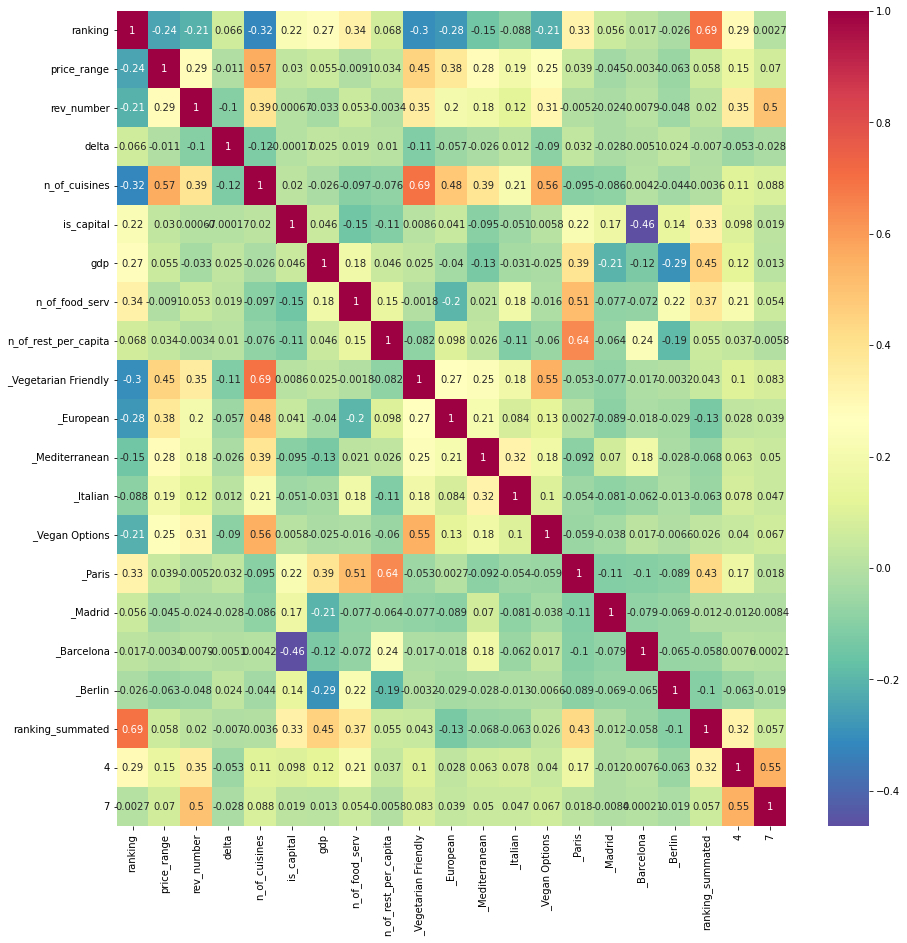

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
# rest_m = rest.loc[:, ['ranking', 'rev_number', 'n_of_cuisines', 'delta', 'population']]
rest_m = rest.drop(['id', 'city', 'cuisine', 'rating', 'reviews',
                    'population', 'n_of_rest', '_London',
                    0, 1, 2, 3, 5, 6, 8, 9],
                   axis=1)
plt.figure(figsize = (15, 15))
sns.heatmap(rest_m.corr(), annot = True, cmap = 'Spectral_r');
rest_m

In [38]:
rest_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ranking               40000 non-null  float64
 1   price_range           40000 non-null  int64  
 2   rev_number            40000 non-null  float64
 3   delta                 40000 non-null  int64  
 4   n_of_cuisines         40000 non-null  int64  
 5   is_capital            40000 non-null  int64  
 6   gdp                   40000 non-null  int64  
 7   n_of_food_serv        40000 non-null  int64  
 8   n_of_rest_per_capita  40000 non-null  float64
 9   _Vegetarian Friendly  40000 non-null  uint8  
 10  _European             40000 non-null  uint8  
 11  _Mediterranean        40000 non-null  uint8  
 12  _Italian              40000 non-null  uint8  
 13  _Vegan Options        40000 non-null  uint8  
 14  other_cuisines        40000 non-null  int64  
 15  _Paris             

# Создаём, обучаем и тестируем модель

1 run MAE: 0.1835625
2 run MAE: 0.179875
3 run MAE: 0.182625
4 run MAE: 0.1831875
5 run MAE: 0.17825

5 runs average MAE: 0.1815


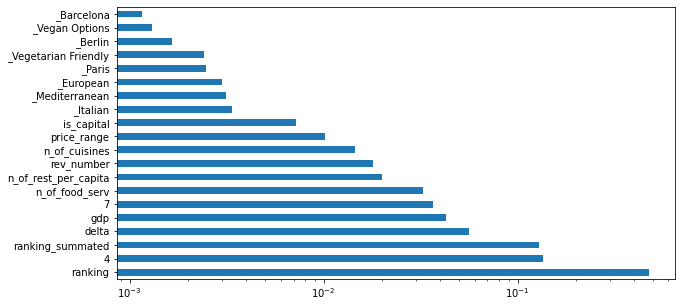

In [45]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = rest.drop(['Restaurant_id', 'Rating'], axis = 1)  
X = rest_m
y = rest.loc[:, 'rating']
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
    # Для тестирования мы будем использовать 25% от исходного датасета.  
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
# Импортируем необходимые библиотеки:  
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

n = 5
mae = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
     
    # Создаём модель
    regr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=1, random_state=RANDOM_SEED)  
      
    # Обучаем модель на тестовом наборе данных  
    regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
    y_pred = regr.predict(X_test)

    y_pred = (y_pred*2).round()/2
 
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
    mae += [metrics.mean_absolute_error(y_test, y_pred)]
    print(f'{i+1} run MAE: {mae[i]}')
print(f'\n{n} runs average MAE: {sum(mae)/len(mae)}')

plt.rcParams['figure.figsize'] = (10, 5)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', log=True);

# 5 runs mean MAE: 0.1856125 - без price_range
# 5 runs mean MAE: 0.18478749999999997 - price_range заполнен с сохранением внутригородского распределения
# 5 runs mean MAE: 0.1867
# 5 runs mean MAE: 0.1820875 - price_range заполнен нулями
# 5 runs mean MAE: 0.1843375 - price_range заполнен нулями, добавлен n_of_rest
# 5 runs mean MAE: 0.1832625 - price_range заполнен нулями,
#                              добавлен n_of_rest_per_capita вместо n_of_rest и population
# 5 runs mean MAE: 0.1825875 - price_range заполнен нулями,
#                              добавлен n_of_rest_per_capita вместо n_of_rest и population,
#                              добавлены dummies-переменные из cuisines
# 5 runs mean MAE: 0.1829